In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import sys

sys.path.append('/home/localssk23/localdp/classification')
from config import CONFIG

#! You need to comment out the sys statements in the config to run this. Need to figure out a fix later.

# Table Builder Functions

In [2]:
def format_overall_results(dataset_name, result_path, num_folds=3):
    all_folds_auc = []
    all_folds_acc = []

    for fold in range(num_folds):
        overall_file = f"{dataset_name}_overall_results_fold_{fold}_Perturbed.csv"
        overall_table = pd.read_csv(Path(result_path) / overall_file)
        
        # Updated column names to match your CSV
        auc_columns = ['Overall_AUC_None', 'Overall_AUC_one'] + \
                     [f'Overall_AUC_{i}' for i in [1, 5, 10, 25, 50, 75, 90, 99]]
        acc_columns = ['Overall_Accuracy_None', 'Overall_Accuracy_one'] + \
                     [f'Overall_Accuracy_{i}' for i in [1, 5, 10, 25, 50, 75, 90, 99]]
        
        fold_auc = pd.DataFrame({
            'Noise Level': ['Original', '1pixel', '1', '5', '10', '25', '50', '75', '90', '99'],
            f'AUC Score Fold {fold}': [overall_table[col].values[0] for col in auc_columns]
        })
        
        fold_acc = pd.DataFrame({
            'Noise Level': ['Original', '1pixel', '1', '5', '10', '25', '50', '75', '90', '99'],
            f'Accuracy Fold {fold}': [overall_table[col].values[0] for col in acc_columns]
        })
        
        all_folds_auc.append(fold_auc)
        all_folds_acc.append(fold_acc)

    combined_auc = all_folds_auc[0]
    combined_acc = all_folds_acc[0]
    for i in range(1, num_folds):
        combined_auc = pd.merge(combined_auc, all_folds_auc[i], on='Noise Level')
        combined_acc = pd.merge(combined_acc, all_folds_acc[i], on='Noise Level')
    
    auc_cols = [col for col in combined_auc.columns if 'AUC' in col]
    acc_cols = [col for col in combined_acc.columns if 'Accuracy' in col]
    
    combined_auc['Mean AUC'] = combined_auc[auc_cols].mean(axis=1)
    combined_acc['Mean Accuracy'] = combined_acc[acc_cols].mean(axis=1)
    
    return combined_auc, combined_acc

In [3]:
def format_class_results(dataset_name, result_path, num_folds=3):
    noise_levels = ['Original', '1pixel'] + [f'{i}' for i in [1, 5, 10, 25, 50, 75, 90, 99]]
    
    fold_data = []
    for fold in range(num_folds):
        class_file = f"{dataset_name}_class_results_fold_{fold}_Perturbed.csv"
        df = pd.read_csv(f"{result_path}/{class_file}")
        fold_data.append(df)
    
    num_classes = len(fold_data[0]['Class'].unique())
    results = {level: {f'class{i}': [] for i in range(num_classes)} for level in noise_levels}
    
    for fold_idx, df in enumerate(fold_data):
        for noise in noise_levels:
            if noise == 'Original':
                col_name = 'Accuracy_None'
            elif noise == '1pixel':
                col_name = 'Accuracy_one'
            else:
                col_name = f'Accuracy_{noise}'
            
            for class_idx in range(num_classes):
                class_value = df[df['Class'] == class_idx][col_name].values[0]
                results[noise][f'class{class_idx}'].append(class_value)
    
    data = []
    for noise in noise_levels:
        row = [noise]
        for fold in range(num_folds):
            for class_idx in range(num_classes):
                row.append(results[noise][f'class{class_idx}'][fold])
        for class_idx in range(num_classes):
            row.append(np.mean(results[noise][f'class{class_idx}']))
        data.append(row)
    
    columns = ['Noise Level']
    for fold in range(num_folds):
        columns.extend([f'Class {i} Fold {fold}' for i in range(num_classes)])
    columns.extend([f'Mean Class {i}' for i in range(num_classes)])
    
    return pd.DataFrame(data, columns=columns)

In [4]:
def create_summary_table(class_results):
   # Get noise levels from first column
   noise_levels = class_results['Noise Level']
   
   # Get number of classes by looking at mean columns
   num_classes = sum(1 for col in class_results.columns if 'Mean Class' in col)
   
   # Create summary data
   summary_data = []
   for idx, noise in enumerate(noise_levels):
       row = [noise]
       for class_idx in range(num_classes):
           # Get columns for this class across all folds
           fold_cols = [col for col in class_results.columns if f'Class {class_idx} Fold' in col]
           mean_value = class_results.loc[idx, fold_cols].mean()
           row.append(mean_value)
       summary_data.append(row)
       
   columns = ['Noise Level'] + [f'Class {i} Mean' for i in range(num_classes)]
   return pd.DataFrame(summary_data, columns=columns)

In [5]:
# Configure paths and datasets
result_path = CONFIG['result_path']
num_folds = 2

# dataset_names = ['breastmnist', 'retinamnist', 'bloodmnist']  # Add more datasets as needed
dataset_names = ['breastmnist', 'retinamnist']  # Add more datasets as needed

# Display cumulative results across folds

In [ ]:
def calculate_and_merge_all_averages(dataset_name, result_path, num_folds):
    # Get overall results
    combined_auc, combined_acc = format_overall_results(dataset_name, result_path, num_folds)
    class_results = format_class_results(dataset_name, result_path, num_folds)
    
    # Get class mean columns
    class_mean_cols = [col for col in class_results.columns if 'Mean Class' in col]
    
    # Create merged DataFrame
    merged_results = pd.DataFrame({
        'Noise Level': combined_auc['Noise Level'],
        'Average AUC': combined_auc.select_dtypes(include=[np.number]).mean(axis=1),
        'Average Accuracy': combined_acc.select_dtypes(include=[np.number]).mean(axis=1)
    })
    
    # Add individual class averages
    for col in class_mean_cols:
        class_idx = col.split()[-1]
        merged_results[f'Class {class_idx} Average'] = class_results[col]
    
    # Calculate and name it as Overall Balanced Accuracy
    merged_results['Overall Balanced Accuracy'] = merged_results[[col for col in merged_results.columns 
                                                            if 'Class' in col]].mean(axis=1)
    
    return merged_results

In [7]:
for dataset in dataset_names:
    print(f"\n{dataset.upper()} Complete Summary")
    print("=" * 50)
    summary = calculate_and_merge_all_averages(dataset, CONFIG['result_path'], num_folds)
    display(summary)


BREASTMNIST Complete Summary


,Noise Level,Average AUC,Average Accuracy,Class 0 Average,Class 1 Average,Overall Balanced Accuracy
0,Original,0.760547,73.076923,0.000000,100.000000,50.000000
1,1pixel,0.755952,73.076923,0.000000,100.000000,50.000000
2,1,0.760443,75.320513,10.714286,99.122807,54.918546
3,5,0.736320,73.076923,0.000000,100.000000,50.000000
4,10,0.739975,73.076923,0.000000,100.000000,50.000000
5,25,0.741124,73.717949,3.571429,99.561404,51.566416
6,50,0.711988,73.076923,0.000000,100.000000,50.000000
7,75,0.642231,73.076923,0.000000,100.000000,50.000000
8,90,0.534252,73.076923,0.000000,100.000000,50.000000
9,99,0.515977,73.076923,0.000000,100.000000,50.000000



RETINAMNIST Complete Summary


,Noise Level,Average AUC,Average Accuracy,Class 0 Average,Class 1 Average,Class 2 Average,Class 3 Average,Class 4 Average,Overall Balanced Accuracy
0,Original,0.681529,47.500,71.839080,0.0,0.0,95.588235,0.0,33.485463
1,1pixel,0.700370,48.625,76.149425,0.0,0.0,91.176471,0.0,33.465179
2,1,0.687641,45.875,87.068966,0.0,0.0,47.058824,0.0,26.825558
3,5,0.677231,48.375,75.000000,0.0,0.0,92.647059,0.0,33.529412
4,10,0.688305,46.000,87.643678,0.0,0.0,46.323529,0.0,26.793442
5,25,0.698399,43.875,81.896552,0.0,0.0,48.529412,0.0,26.085193
6,50,0.654962,43.500,100.000000,0.0,0.0,0.000000,0.0,20.000000
7,75,0.586222,43.500,100.000000,0.0,0.0,0.000000,0.0,20.000000
8,90,0.534635,43.500,100.000000,0.0,0.0,0.000000,0.0,20.000000
9,99,0.494326,43.500,100.000000,0.0,0.0,0.000000,0.0,20.000000


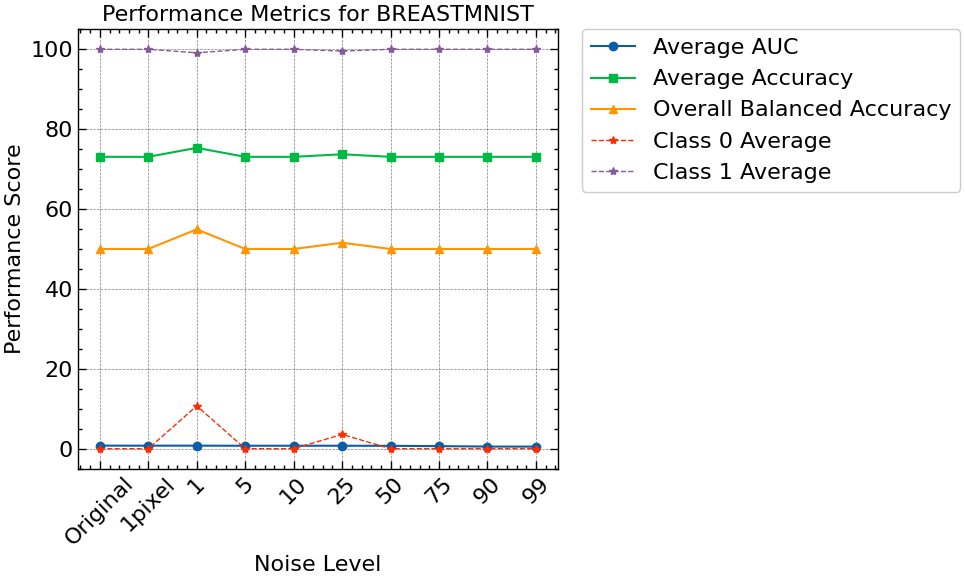

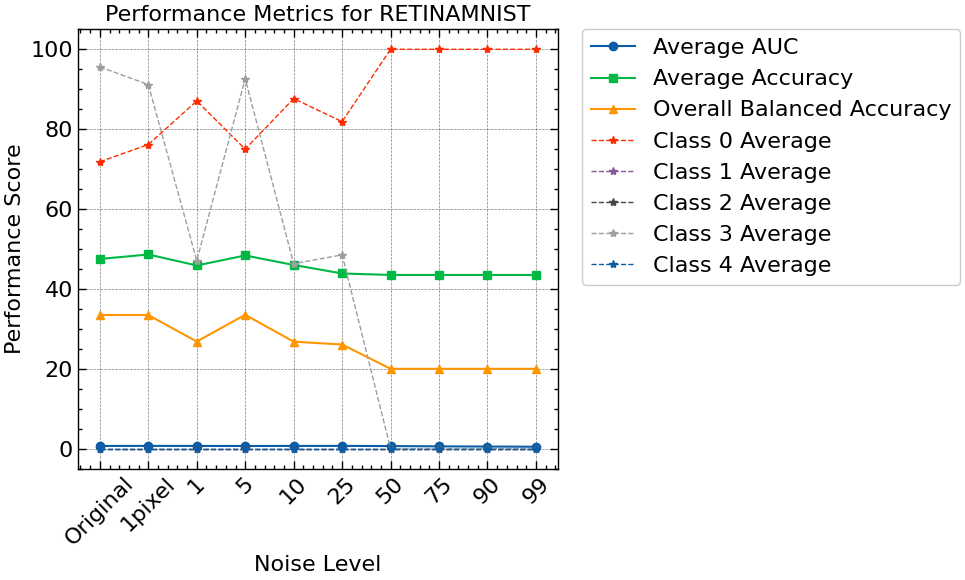

In [12]:
import matplotlib.pyplot as plt
import scienceplots

def plot_results_with_scienceplots(merged_results, dataset_name):
    plt.style.use(['science', 'notebook', 'grid'])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot main metrics with thicker lines
    ax.plot(merged_results['Noise Level'], merged_results['Average AUC'], 
            marker='o', linewidth=1.5, label='Average AUC')
    ax.plot(merged_results['Noise Level'], merged_results['Average Accuracy'], 
            marker='s', linewidth=1.5, label='Average Accuracy')
    ax.plot(merged_results['Noise Level'], merged_results['Overall Balanced Accuracy'], 
            marker='^', linewidth=1.5, label='Overall Balanced Accuracy')
    
    # Plot individual class averages with dashed lines
    for col in merged_results.columns:
        if 'Class' in col and 'Overall' not in col:
            ax.plot(merged_results['Noise Level'], merged_results[col], 
                   marker='*', linestyle='--', linewidth=1, label=col)
    
    ax.set_xlabel('Noise Level')
    ax.set_ylabel('Performance Score')
    ax.set_title(f'Performance Metrics for {dataset_name.upper()}')
    
    # Customize legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
             borderaxespad=0, frameon=True)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Usage
dataset_names = ['breastmnist', 'retinamnist']
for dataset in dataset_names:
    summary = calculate_and_merge_all_averages(dataset, CONFIG['result_path'], num_folds)
    plot_results_with_scienceplots(summary, dataset)

# Display Fold Wise Results

In [8]:
for dataset_name in dataset_names:
    print(f"\nResults for {dataset_name}")
    print("=" * 50)
    
    # Get overall results
    combined_auc, combined_acc = format_overall_results(dataset_name, result_path, num_folds)
    print("\nOverall AUC Scores:")
    print(combined_auc.to_string(index=False))
    print("\nOverall Accuracy Scores:")
    print(combined_acc.to_string(index=False))
    
    # Get class-wise results
    class_results = format_class_results(dataset_name, result_path, num_folds)
    print("\nClass-wise Accuracy Scores:")
    print(class_results.to_string(index=False))

    # Fold wise class wise mean    
    summary_results = create_summary_table(class_results)
    print("\nSummary Across All Folds:")
    print(summary_results.to_string(index=False))
    print()


Results for breastmnist

Overall AUC Scores:
Noise Level  AUC Score Fold 0  AUC Score Fold 1  Mean AUC
   Original          0.761905          0.759190  0.760547
     1pixel          0.734127          0.777778  0.755952
          1          0.762114          0.758772  0.760443
          5          0.729741          0.742899  0.736320
         10          0.746241          0.733709  0.739975
         25          0.713241          0.769006  0.741124
         50          0.727026          0.696951  0.711988
         75          0.643693          0.640769  0.642231
         90          0.494570          0.573935  0.534252
         99          0.539891          0.492063  0.515977

Overall Accuracy Scores:
Noise Level  Accuracy Fold 0  Accuracy Fold 1  Mean Accuracy
   Original        73.076923        73.076923      73.076923
     1pixel        73.076923        73.076923      73.076923
          1        73.076923        77.564103      75.320513
          5        73.076923        73.076923 

# Gaussian Based Results

In [17]:
class_results_df = pd.read_csv('/home/localssk23/localdp/classification/results/breastmnist_class_results_fold_0_Gaussian.csv')
print(class_results_df.to_string(index=False))

overall_results_df = pd.read_csv('/home/localssk23/localdp/classification/results/breastmnist_overall_results_fold_0_Gaussian.csv')
print(overall_results_df.to_string(index=False))

    Dataset  Class  Accuracy_1  Accuracy_5  Accuracy_10  Accuracy_25  Accuracy_50  Accuracy_75  Accuracy_90  Accuracy_99
breastmnist      0   16.666667    4.761905          0.0     9.523810          0.0          0.0          0.0          0.0
breastmnist      1   99.122807   99.122807        100.0    99.122807        100.0        100.0        100.0        100.0
    Dataset  Overall_Accuracy_1  Overall_AUC_1  Overall_Accuracy_5  Overall_AUC_5  Overall_Accuracy_10  Overall_AUC_10  Overall_Accuracy_25  Overall_AUC_25  Overall_Accuracy_50  Overall_AUC_50  Overall_Accuracy_75  Overall_AUC_75  Overall_Accuracy_90  Overall_AUC_90  Overall_Accuracy_99  Overall_AUC_99
breastmnist           76.923077       0.770259           73.717949       0.747076            73.076923        0.743525                 75.0        0.773392            73.076923        0.705514            73.076923        0.638471            73.076923        0.670008            73.076923        0.700919


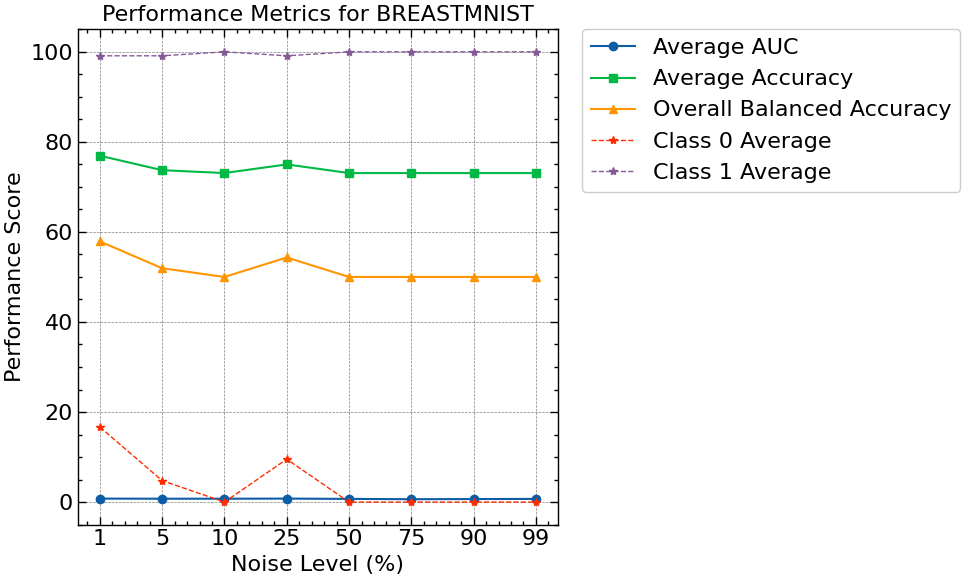

In [27]:
def calculate_and_merge_all_averages_new(dataset_name, class_df, overall_df):
    # Create merged DataFrame with noise levels
    noise_levels = ['1', '5', '10', '25', '50', '75', '90', '99']
    merged_results = pd.DataFrame({'Noise Level': noise_levels})
    
    # Add AUC and Overall Accuracy
    merged_results['Average AUC'] = [overall_df[f'Overall_AUC_{level}'].values[0] 
                                   for level in noise_levels]
    merged_results['Average Accuracy'] = [overall_df[f'Overall_Accuracy_{level}'].values[0] 
                                        for level in noise_levels]
    
    # Add individual class accuracies
    num_classes = len(class_df['Class'].unique())
    for class_idx in range(num_classes):
        class_data = class_df[class_df['Class'] == class_idx]
        merged_results[f'Class {class_idx} Average'] = [class_data[f'Accuracy_{level}'].values[0] 
                                                      for level in noise_levels]
    
    # Calculate Overall Balanced Accuracy
    class_cols = [col for col in merged_results.columns if 'Class' in col]
    merged_results['Overall Balanced Accuracy'] = merged_results[class_cols].mean(axis=1)
    
    return merged_results

def plot_results_with_scienceplots(merged_results, dataset_name):
    plt.style.use(['science', 'notebook', 'grid'])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot main metrics with thicker lines
    ax.plot(merged_results['Noise Level'], merged_results['Average AUC'], 
            marker='o', linewidth=1.5, label='Average AUC')
    ax.plot(merged_results['Noise Level'], merged_results['Average Accuracy'], 
            marker='s', linewidth=1.5, label='Average Accuracy')
    ax.plot(merged_results['Noise Level'], merged_results['Overall Balanced Accuracy'], 
            marker='^', linewidth=1.5, label='Overall Balanced Accuracy')
    
    # Plot individual class averages with dashed lines
    for col in merged_results.columns:
        if 'Class' in col and 'Overall' not in col:
            ax.plot(merged_results['Noise Level'], merged_results[col], 
                   marker='*', linestyle='--', linewidth=1, label=col)
    
    ax.set_xlabel('Noise Level (%)')
    ax.set_ylabel('Performance Score')
    ax.set_title(f'Performance Metrics for {dataset_name.upper()}')
    
    # Customize legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
             borderaxespad=0, frameon=True)
    
    plt.tight_layout()
    plt.show()

# Usage example:
# Assuming your dataframes are named class_results_df and overall_results_df
dataset_name = 'breastmnist'
summary = calculate_and_merge_all_averages_new(dataset_name, class_results_df, overall_results_df)
plot_results_with_scienceplots(summary, dataset_name)

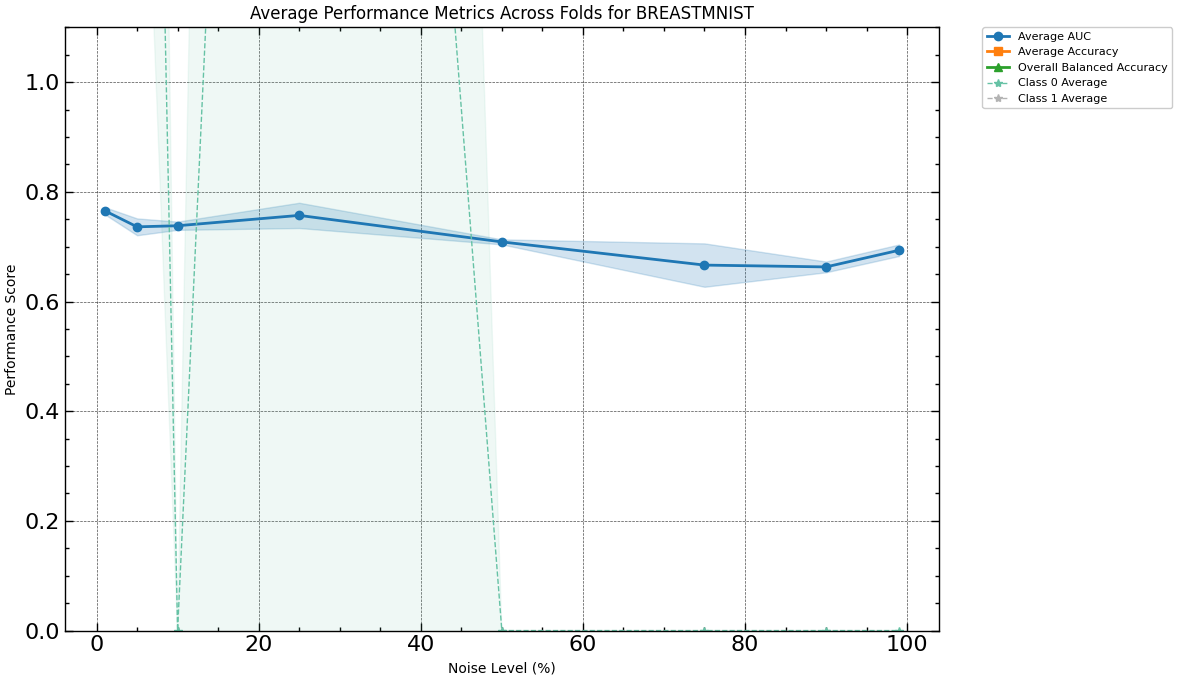

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

def calculate_and_merge_all_averages_new(dataset_name, class_df, overall_df):
    # Create merged DataFrame with noise levels
    noise_levels = ['1', '5', '10', '25', '50', '75', '90', '99']
    merged_results = pd.DataFrame({'Noise Level': noise_levels})
    
    # Add AUC and Overall Accuracy
    merged_results['Average AUC'] = [overall_df[f'Overall_AUC_{level}'].values[0] 
                                   for level in noise_levels]
    merged_results['Average Accuracy'] = [overall_df[f'Overall_Accuracy_{level}'].values[0] 
                                        for level in noise_levels]
    
    # Add individual class accuracies
    num_classes = len(class_df['Class'].unique())
    for class_idx in range(num_classes):
        class_data = class_df[class_df['Class'] == class_idx]
        merged_results[f'Class {class_idx} Average'] = [class_data[f'Accuracy_{level}'].values[0] 
                                                      for level in noise_levels]
    
    # Calculate Overall Balanced Accuracy
    class_cols = [col for col in merged_results.columns if 'Class' in col]
    merged_results['Overall Balanced Accuracy'] = merged_results[class_cols].mean(axis=1)
    
    return merged_results
def process_all_folds(base_path, dataset_name, noise_type='Gaussian'):
    all_fold_results = []
    
    # Get all fold files for the dataset
    class_pattern = f'{base_path}/classification/results/{dataset_name}_class_results_fold_*_{noise_type}.csv'
    overall_pattern = f'{base_path}/classification/results/{dataset_name}_overall_results_fold_*_{noise_type}.csv'
    
    class_files = sorted(glob.glob(class_pattern))
    overall_files = sorted(glob.glob(overall_pattern))
    
    # Process each fold
    for class_file, overall_file in zip(class_files, overall_files):
        fold_num = int(class_file.split('fold_')[1].split('_')[0])
        
        # Read fold data
        class_df = pd.read_csv(class_file)
        overall_df = pd.read_csv(overall_file)
        
        # Calculate metrics for this fold
        fold_results = calculate_and_merge_all_averages_new(dataset_name, class_df, overall_df)
        fold_results['Fold'] = fold_num
        all_fold_results.append(fold_results)
    
    # Combine all folds
    combined_results = pd.concat(all_fold_results)
    
    # Convert Noise Level to numeric and other columns to float
    combined_results['Noise Level'] = pd.to_numeric(combined_results['Noise Level'])
    value_columns = combined_results.columns.difference(['Noise Level', 'Fold'])
    
    for col in value_columns:
        combined_results[col] = pd.to_numeric(combined_results[col], errors='coerce')
    
    # Group by Noise Level and calculate mean and std
    final_results = combined_results.groupby('Noise Level')[value_columns].mean().reset_index()
    std_results = combined_results.groupby('Noise Level')[value_columns].std().reset_index()
    
    return final_results, std_results


def plot_results_with_confidence(final_results, std_results, dataset_name):
    plt.style.use(['science', 'notebook', 'grid'])
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot main metrics with confidence intervals
    metrics = ['Average AUC', 'Average Accuracy', 'Overall Balanced Accuracy']
    markers = ['o', 's', '^']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for metric, marker, color in zip(metrics, markers, colors):
        mean_values = final_results[metric]
        std_values = std_results[metric]
        
        ax.plot(final_results['Noise Level'], mean_values, 
                marker=marker, linewidth=2, label=metric, color=color)
        ax.fill_between(final_results['Noise Level'], 
                       mean_values - std_values, 
                       mean_values + std_values, 
                       alpha=0.2, color=color)
    
    # Plot individual class averages
    class_columns = [col for col in final_results.columns if 'Class' in col and 'Overall' not in col]
    class_colors = plt.cm.Set2(np.linspace(0, 1, len(class_columns)))
    
    for col, color in zip(class_columns, class_colors):
        mean_values = final_results[col]
        std_values = std_results[col]
        
        ax.plot(final_results['Noise Level'], mean_values, 
               marker='*', linestyle='--', linewidth=1, label=col, color=color)
        ax.fill_between(final_results['Noise Level'], 
                      mean_values - std_values, 
                      mean_values + std_values, 
                      alpha=0.1, color=color)
    
    ax.set_xlabel('Noise Level (%)', fontsize=10)
    ax.set_ylabel('Performance Score', fontsize=10)
    ax.set_title(f'Average Performance Metrics Across Folds for {dataset_name.upper()}', fontsize=12)
    
    # Improve legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
             borderaxespad=0, frameon=True, fontsize=8)
    
    # Grid and axis settings
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()

# Usage
base_path = '/home/localssk23/localdp'
datasets = ['breastmnist']  # Add other datasets as needed

for dataset in datasets:
    final_results, std_results = process_all_folds(base_path, dataset)
    plot_results_with_confidence(final_results, std_results, dataset)


In [32]:
#! Need to generate this so I can show STD over the plots for everyting. This is the final plots.